<h1><center>Laboratorio 8: ¿Superhéroe o Villano? 🦸</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Matías Rojas y Mauricio Araneda
- Auxiliar: Ignacio Meza D.
- Ayudante: Rodrigo Guerra

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Johnny Godoy


### **Link de repositorio de GitHub:** `https://github.com/johnny-godoy/laboratorios-mds/blob/main/lab%208/laboratorio_8.ipynb`

## Temas a tratar

- Codificación de texto usando Bag of Words.
- Búsqueda del modelo óptimo de clasificación usando `GridSearch`
- Uso de pipelines.

## Reglas:

- **Grupos de 2 personas**
- **Ausentes** deberán realizar la actividad solos. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Obtener caracteristicas a partir de texto usando `CountVectorizer`.
- Fijar un pipeline con un modelo base que luego se irá optimizando.
- Comprender como realizar una búsqueda de grilla sobre un conjunto de clasificadores e hiperparámetros usando `GridSearch`.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

In [1]:
# Librería Core del lab.
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split

# Pre-procesamiento
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

# Clasifación
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Metricas de evaluación
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

# Librería para plotear
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Proyecciones en baja dimensionalidad: UMAP

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. ¿Quien es Bat Cow?

<p align="center">
  <img src="https://i.imgur.com/D9f1RHy.jpg" width="350">
</p>

En vez de estar desarrollando las evaluaciones correspondientes a su curso, su profesor de catedra y su auxiliar discuten acerca la alineación (héroe o villano) del personaje de ficción Bat-Cow. 

El cuerpo docente, no logra ponerse de acuerdo si el personaje es bueno, neutral o malo: el auxiliar plantea que Bat-cow posee una siniestra mirada, intrigante pero común característica de los personajes malvados. 
Por otra parte, extendiendo las ideas de Rousseau, el profesor plantea que tal como los humanos no nacen malos, no existe motivo por el cual una vaca con superpoderes deba serlo.

Sin embargo, ambos concuerdan que es difícil estimar la alineación solo usando los atributos físicos, por lo que creen el análisis debe ser complementado aún más antes de comunicarle los resultados a su estudiantado. Buscando más información, ambos sujetos se percatan de la existencia de un excelente antecedente para estimar la alineación: la historia personal de cada superhéroe o villano.

Es por esto le solicitan que construya y optimice un clasificador basado en texto el cual analice la alineación de cada personaje basado en su historia personal.

Para este laboratorio deben trabajar con los datos `df_comics.csv` y `comics_no_label.csv` subidos a u-cursos. El primero es un conjunto de datos que les servirá para entrenar un modelo de clasificación, mientras que el segundo es un dataset con personajes de ficción no etiquetados a predecir (sí, aquí está la misteriosa Batcow).

Para comenzar cargue los dataset señalados y visualice a través de un head los atributos que poseen cada uno de los dataset.


In [3]:
df_comics = pd.read_csv('data/df_comics.csv')
df_comics_no_label = pd.read_csv('data/comics_no_label.csv')
df_comics = df_comics.dropna(subset=['history_text']) # eliminar ejemplos sin historia

In [4]:
# queda a labor de su equipo hacer el análisis exploratorio
df_comics.head()

,Unnamed: 0,name,real_name,full_name,overall_score,history_text,powers_text,intelligence_score,strength_score,speed_score,...,has_flight,has_accelerated_healing,has_weapons_master,has_intelligence,has_reflexes,has_super_speed,has_durability,has_stamina,has_agility,has_super_strength
0,0,3-D Man,"Delroy Garrett, Jr.","Delroy Garrett, Jr.",6,"Delroy Garrett, Jr. grew up to become a track ...",NaN,85,30,60,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2,A-Bomb,Richard Milhouse Jones,Richard Milhouse Jones,20,"Richard ""Rick"" Jones was orphaned at a young ...","On rare occasions, and through unusual circu...",80,100,80,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,Aa,Aa,NaN,12,Aa is one of the more passive members of the P...,NaN,80,50,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Aaron Cash,Aaron Cash,Aaron Cash,5,Aaron Cash is the head of security at Arkham A...,NaN,80,10,25,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Aayla Secura,Aayla Secura,NaN,8,ayla Secura was a Rutian Twi'lek Jedi Knight (...,NaN,90,40,45,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Haremos un poco de exploración simple. Primero eliminemos el índice

In [5]:
exploration_df = df_comics.drop("Unnamed: 0", axis=1)  # Este df lo modificaremos libremente en exploración

Veamos la distribución de las categorías

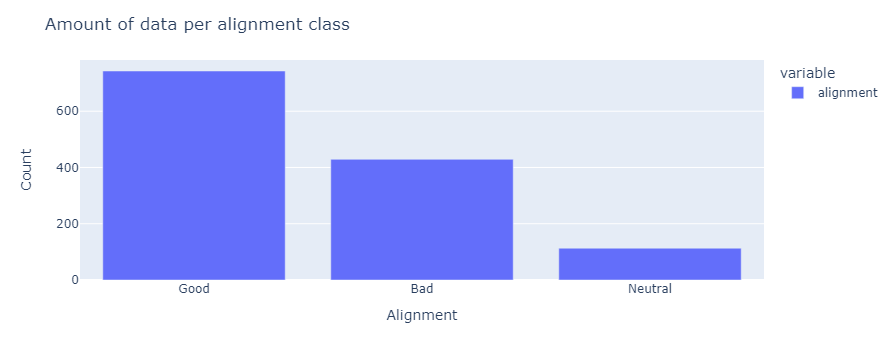

In [51]:
fig = px.bar(exploration_df.alignment.value_counts())
fig.update_layout(xaxis_title="Alignment",
                  yaxis_title="Count",
                  title="Amount of data per alignment class")
fig

Observamos que el problema de clasificación está desbalanceado. Ahora veamos las features, empezando por las enteras:

In [52]:
exploration_df.select_dtypes("int")

,intelligence_score,strength_score,speed_score,durability_score,power_score,combat_score
0,85,30,60,60,40,70
1,80,100,80,100,100,80
2,80,50,55,45,100,55
3,80,10,25,40,30,50
4,90,40,45,55,55,85
...,...,...,...,...,...,...
1362,90,10,25,30,100,55
1363,80,100,100,100,100,80
1364,95,50,100,75,100,80
1365,75,10,100,30,100,30


Estos son precisamente los atributos de interés que aparecerán luego. Veamos sus distribuciones

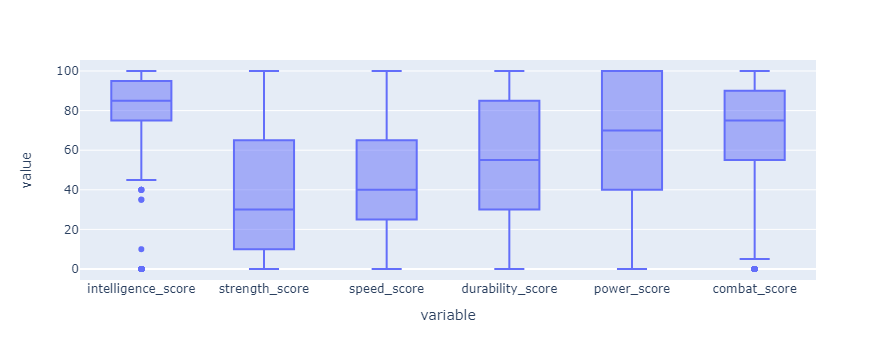

In [53]:
exploration_df.select_dtypes("int").boxplot()

Agrupando ahora por la variable de respuesta

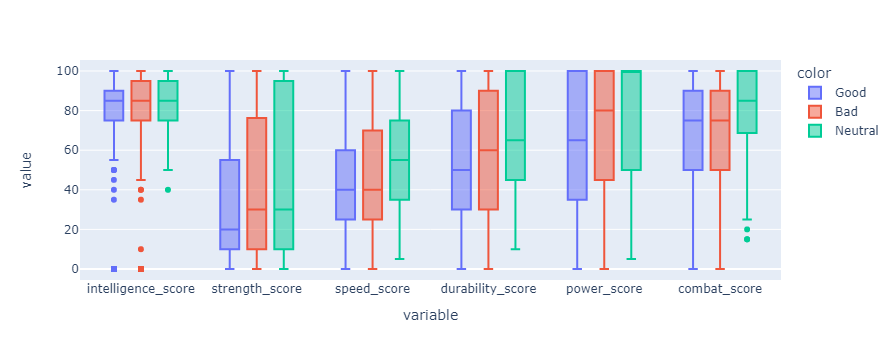

In [54]:
px.box(exploration_df.select_dtypes("int"), color=exploration_df.alignment)

No se ven patrones que permitan una clasificación trivial. Ahora se ven los objetos.

In [8]:
exploration_df.select_dtypes("object").columns

Index(['name', 'real_name', 'full_name', 'overall_score', 'history_text',
       'powers_text', 'superpowers', 'alter_egos', 'aliases', 'place_of_birth',
       'first_appearance', 'creator', 'alignment', 'occupation', 'base',
       'teams', 'relatives', 'gender', 'type_race', 'height', 'weight',
       'eye_color', 'hair_color', 'skin_color', 'img'],
      dtype='object')

In [9]:
exploration_df.select_dtypes("object").nunique().sort_values(ascending=False)

name                1285
history_text        1274
img                 1215
superpowers         1166
first_appearance    1003
real_name            971
powers_text          939
aliases              860
full_name            794
relatives            775
occupation           753
base                 519
alter_egos           463
place_of_birth       422
teams                390
weight               242
height               116
overall_score         87
type_race             63
creator               39
hair_color            30
eye_color             25
skin_color            15
alignment              3
gender                 2
dtype: int64

Es extraño que el nombre real no sea único: Esto puede ocurrir porque existen varias variantes del mismo personaje (distintas historias). Esto puede causar un sesgo en validación si es que un mismo personaje queda con distintas variantes en distintos splits (dado que en general seguiran alineados de la misma forma), pero por simplicidad ignoraremos esto.

Había realizado más análisis de otras características, pero decidí eliminarlo dado que nos concentraremos solamente en estas durante el laboratorio.

## 1.1 Obtención de Features y Bag of Words

<p align="center">
  <img src="https://media0.giphy.com/media/eIUpSyzwGp0YhAMTKr/200.gif" width="300">
</p>

Primero que todo, deben obtener un vector de características del atributo `history_text`, utilizando `Bag of Words`. En este atributo se presenta una breve descripción de la historia de cada uno de los personajes de ficción presentes en el dataset. 

Pero... antes de empezar, ¿Que es `Bag of Words`?...

`Bag of Words` es un modelo de conteo utilizado en Procesamiento de Lenguaje Natural (NLP) que tiene como objetivo generar una representación vectorial (vector de características en nuestro cas) para cada documento a través del conteo de las palabras que contienen. 

La siguiente figura muestra un ejemplo de `Bag of Words` en acción:

<p align="center">
  <img src="https://user.oc-static.com/upload/2020/10/23/16034397439042_surfin%20bird%20bow.png" width="500">
</p>

Como pueden ver, el modelo de `Bag of Words` no resulta tan complicado, ¿pero cómo lo aplicamos en python?. 

Como podrán darse cuenta del ejemplo anterior, para facilitar el conteo será necesario transformar cada uno de los documentos en vectores, donde cada una de las posiciones posee un carácter. Este proceso es conocido como **tokenización** y lo podemos realizar de la siguiente forma:

In [10]:
docs = ['The teacher rocks like a good rock & roll',
             'the rock is the best actor in the world']


docs_tokenizados = [word_tokenize(doc)  for doc in docs]
docs_tokenizados

[['The', 'teacher', 'rocks', 'like', 'a', 'good', 'rock', '&', 'roll'],
 ['the', 'rock', 'is', 'the', 'best', 'actor', 'in', 'the', 'world']]

Podemos mejorar un poco más el proceso de tokenización agregando 

- Stemming:  Definimos Stemming como un algoritmo basado en reglas que transforma las palabras a una forma general. Un ejemplo de stemming, es el siguiente:
- Eliminación de Stopwords: Eliminación de palabras muy frecuentes que entorpecen la clasificación (por ejemplo, el, la los, la, etc...)

<p align="center">
  <img src="https://devopedia.org/images/article/218/8583.1569386710.png" width="300">
</p>


In [11]:
stop_words = stopwords.words('english')  # stopwords.words('spanish')

# Definimos un tokenizador con Stemming
class StemmerTokenizer:
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, doc):
        doc_tok = word_tokenize(doc)
        doc_tok = [t for t in doc_tok if t not in stop_words]
        return [self.ps.stem(t) for t in doc_tok]

# Inicializamos tokenizador
tokenizador = StemmerTokenizer()

# Creamos algunos documentos
docs = ['The teacher rocks like a good rock & roll',
        'the rock is the best actor in the world',
        'New York is a beautiful city']

# Obtenemos el token del primer documento
[tokenizador(doc) for doc in docs]

[['the', 'teacher', 'rock', 'like', 'good', 'rock', '&', 'roll'],
 ['rock', 'best', 'actor', 'world'],
 ['new', 'york', 'beauti', 'citi']]

In [12]:
# Comparación con el caso anterior
docs_tokenizados = [word_tokenize(doc) for doc in docs]
docs_tokenizados

[['The', 'teacher', 'rocks', 'like', 'a', 'good', 'rock', '&', 'roll'],
 ['the', 'rock', 'is', 'the', 'best', 'actor', 'in', 'the', 'world'],
 ['New', 'York', 'is', 'a', 'beautiful', 'city']]

#### Al Estilo Scikit

Scikit implementa `bag of words` a través de la clase `CountVectorizer()` la cual contiene muchas opciones para mejorar la tokenización.

In [13]:
bow = CountVectorizer(tokenizer=StemmerTokenizer())
df = bow.fit_transform(docs)

pd.DataFrame(df.toarray(), columns=bow.get_feature_names_out())

,&,actor,beauti,best,citi,good,like,new,rock,roll,teacher,world,york
0,1,0,0,0,0,1,1,0,2,1,1,0,0
1,0,1,0,1,0,0,0,0,1,0,0,1,0
2,0,0,1,0,1,0,0,1,0,0,0,0,1


Una de las cosas más interesantes que provee son el use de n-gramas, los cuales, en palabras simples, son conjuntos de n-palabras que se concatenan entre si y que se consideran como tokens separados. 

Pensemos en `Nueva York`. Cuando se tokeniza Nueva York, se generan dos tokens independientes que a simple vista no tienen relación: `Nueva` `York`.
Al usar n-gramas (en un rango min=1,max=2) , generamos tanto `Nueva` y `York` como también `Nueva York` como un token independiente.

In [14]:
bow = CountVectorizer(tokenizer=StemmerTokenizer(), ngram_range=(1,2))
df = bow.fit_transform(docs)

pd.DataFrame(df.toarray(), columns=bow.get_feature_names_out())

,&,& roll,actor,actor world,beauti,beauti citi,best,best actor,citi,good,...,rock,rock &,rock best,rock like,roll,teacher,teacher rock,world,york,york beauti
0,1,1,0,0,0,0,0,0,0,1,...,2,1,0,1,1,1,1,0,0,0
1,0,0,1,1,0,0,1,1,0,0,...,1,0,1,0,0,0,0,1,0,0
2,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1


De los resultados, podemos ver que generamos vectores de conteo para cada una de las palabras que conforman el corpus.  Un punto extra que se agrega en esta obtención de frecuencias son los bigramas, que básicamente son el conjunto de palabras de tamaño de aparecen juntas en el texto.

## Codificando los Super{heroes, villanos}  [0.5 Puntos]

<p align="center">
  <img src="https://c.tenor.com/LkQzw7k5DV4AAAAd/anime-hacking.gif" width="300">
</p>

Conociendo ahora que es el proceso de `bag of words`, aplique este modelo de obtención de caracteristicas de la siguiente forma en un pipeline:

- Utilice el tokenizador entregado.
- Obtenga caracteristicas de los unigramas y bigramas del texto (tal como el ejemplo).

```python
bog = CountVectorizer(tokenizer= StemmerTokenizer(),`
                      ngram_range=(1,2) # Este punto es opcional y es para generar bigramas
                      )
```

Finalmente, aplique `MinMaxScaler()` sobre `atributos_de_interes` y concatene el valor obtenido con el matriz de caracteristicas obtenidas con bag of words.

```python
atributos_de_interes = ['intelligence_score', 'strength_score', 'speed_score', 'durability_score', 'power_score', 'combat_score']
```

No es necesario que obtenga un dataframe en concreto con las características solicitadas. Se le recomienda generar un `ColumnTransformer()` para aplicar las transformaciones solicitadas en un pipeline.

**To-Do:**
- [x] Obtener a traves de Bag of Words (`CountVectorizer`) caracteristicas del resumen de historia de cada personaje.
- [x Aplicar `MinMaxScaler` sobre los atributos de interes.

**Respuesta:**

In [15]:
transformer = ColumnTransformer([("score_scaler", MinMaxScaler(), df_comics.select_dtypes("int").columns),
                                 ("bag_of_words", CountVectorizer(tokenizer=StemmerTokenizer(), ngram_range=(1,2)), "history_text"),
                                ]
                               )

De todos modos vale la pena ver el dataframe en concreto resultante

## 1.2 Diseño de Baseline y  Primer Entrenamiento  [1 Puntos]


<p align="center">
  <img src="https://pa1.narvii.com/6374/9eaec1b7bf9157334151452a669516f9a78b954c_hq.gif" width="300">
</p>



Genere un Pipeline con las caracteristicas solicitadas en la sección 1.1, un selector de mejores features `SelectPercentile` con métrica `f_classif` y percentile=90 y un clasificador `MultinomialNB()` por defecto.

Luego, separe el conjunto de datos en un conjunto de entrenamiento y prueba, donde las etiquetas estará dado por el atributo `alignment`. 

Entrene el modelo y reporte el desempeño con un `classification_report`. ¿ Nos recomendaría predecir la alineación de BatCow con este clasificador?.

Finalmente, compare el modelo entrenado con un modelo Dummy estratificado y responda: ¿El clasificador entrenado es mejor que el dummy que entrega respuestas al azar?

**To-do:**
- [x] Realizar un pipeline con las caracteristicas solicitadas en 1.1, ejecutar holdout y aplicar un clasificador `MultinomialNB()`.
- [x] Entrenar el pipeline, calcular el `classification_report` asociado y comentar los resultados.
- [x] Entrenar un `DummyClassifier` con estrategia `statified`, calcular el `classification_report` asociado y comentar que implican los scores obtenidos en comparación con los resultados del baseline.

**Respuesta:**

Creando el Pipeline

In [16]:
feature_pipeline = make_pipeline(transformer,
                                 SelectPercentile(score_func=f_classif,
                                                  percentile=90)
                                )
nb_clf = make_pipeline(feature_pipeline,
                       MultinomialNB(alpha=.5)
                      )

Preparando los datos

In [23]:
X = df_comics.drop("alignment", axis=1)
y = df_comics.alignment

Dado el desbalance ya determinado, realizamos el holdout con estratificación.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
                                                    stratify=y)

Entrenando el pipeline, y ver el `classification_report`

In [38]:
y_pred = nb_clf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Bad       0.68      0.25      0.36       108
        Good       0.63      0.94      0.76       186
     Neutral       0.17      0.04      0.06        28

    accuracy                           0.63       322
   macro avg       0.49      0.41      0.39       322
weighted avg       0.61      0.63      0.57       322



Analizando el desempeño según cada clase:

* Buenos: Alto desempeño tanto en precisión como recall, se discrimina cuando alguien es bueno o no. El recall es más alto que la precisión, así que tal vez se subestima la cantidad de buenos.
* Malos: Acá vemos mejor precisión que recall, en contraste al caso anterior, subestima la cantidad de malos, pero en una proporción mucho mayor, 
* Neutros: Esta es la clase minoritaria, y es donde vemos peores puntajes, con un pésimo f1-score.

In [39]:
y_pred = DummyClassifier(strategy="stratified").fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Bad       0.39      0.36      0.38       108
        Good       0.61      0.65      0.63       186
     Neutral       0.15      0.14      0.15        28

    accuracy                           0.51       322
   macro avg       0.39      0.38      0.39       322
weighted avg       0.50      0.51      0.50       322



```
Escriba aquí su justificación
```

## 1.3 Busqueda del Mejor Modelo con Grid Search [4 Puntos]

<p align="center">
  <img src="https://media1.tenor.com/images/70fdfeea52a8e2e4505498c230a0d2f9/tenor.gif?itemid=5134219" width="250">
</p>

No conformes con el rendimiento obtenido en la sección 1.2, el cuerpo docente les pide que realicen un **`HalvingGridSearchCV`** con diferentes parámetros para mejorar el rendimiento de la clasificación. Para esto, se le solicita que defina:

- Tres clasificadores distintos en donde varie sus parámetros. Considere usar modelos clásicos como también los basados en ensamblaje.
- Modificar `n-gram` range del `CountVectorizer` probando `(1,1), (1,2) y (1,3)`. Examinar también los otros parámetros de CountVectorizer como por ejemplo `max_df`, `min_df`, etc... ([Documentación aquí](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html))
- Seleccionar las columnas que contribuyen con la mayor información para la clasificación con `SelectPercentile` en los percentiles `[20, 40, 60, 80]` (puede usar la métrica que usted quiera).
- Reporte la mejor combinación encontrada y justifique por qué cree que es la mejor según el clasificador usado, la cantidad de columnas seleccionadas y los parámetros de CountVectorizer seleccionados por GridSearch.

A continuación, un ejemplo de parametros para GridSearch para una búsqueda de 3 clasificadores distintos:

```python
params = [
       # clasificador 1 + hiperparámetros
       {'clf': classificator1(),
        'clf__penalty': ['ovr'],
       # clasificador 1 + hiperparámetros    
       {'clf': classificator2(),
        'clf__n_estimators': [200]},
       # clasificador 1 + hiperparámetros
       {'clf': classificator3(),
        ...
       }
       ]
```

**Nota 1**: Puede ver los parámetros modificables aplicando el método get_params() sobre su pipeline. Ver la clase de GridSearch para mayor información sobre la sintáxis de las grillas.

**Nota 2**: Recuerde inicializar los clasificadores con un random state definido.

**Nota 3**: Puede usar en `HalvingGridSearchCV` el parámetro `verbose=10` para ver que GridSearch le indique el estado de su ejecución.

**Nota 3:** El GridSearch puede tomar tiempos de búsqueda exorbitantes, por lo que se le recomienda no agrandar mucho el espacio de búsqueda, dejar corriendo el código y tomarse un tecito.

**Respuesta:**

Los modelos a elegir se basarán en la guía de sklearn:

* MultinomialNB, modificando hiperparámetros
* SVM, tanto lineal como rbf, que son recomendados a probar
* RandomForest como elección de modelo de ensamblaje

In [ ]:
#### Código aquí ####

```
Escriba aquí su justificación
```

## 1.4 Predicción del datos sin etiquetado  [0.5 puntos]

<p align="center">
  <img src="https://pbs.twimg.com/media/DolotxUUYAAbg7f.jpg" width="350">
</p>


LLego el momento de predecir 
`Vergil`, `Gorilla Girl` y `Batcow`


**Nota:** Recuerde que pueden existir campos vacios en `history_text`, por lo que se les recomienda borrar los nan.

In [58]:
df_comics_no_label.history_text.isna().sum()

8

**Respuesta:**

In [ ]:
#### Código aquí ####

<p align="center">
  <img src="https://media1.tenor.com/images/fb5bf7cc5a4acb91b4177672886a88ba/tenor.gif?itemid=5591338">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>